# Hierarchical Bayesian Neural Networks

(c) 2018 by Thomas Wiecki

Imagine you have a ML problem with small data. Despite what most flashy news articles try to make you believe, yes, this does exist. This can happen especially if your problem space consists of many different sub-categories. This happens, for example, in ad-tech where you have many products but for each product only a small number of measurements (i.e. click-through rates). Products can belong to different categories and share similarities with other products in the same category. The prediction problem is whether the user entering a search-term will likely buy this product or not.

Using classic Machine Learning (ML) methods is unlikely to yield good results in this setting. Firstly, ML is happiest with lots of data and deep learning is usually only happy with even more data. Moreover, we can't really make use of the hierarchical structure (product-groupings) we know to be present in our data. So we can either ignore it and try to learn one model for all categories which does not allow us to capture the differences between categories; or we can fit a ML model to each category separately but do not exploit the similarities between categories.

Hierarchical Bayesian models work amazingly well in exactly this setting as they allow us to build a model that matches the hierarchical structure present in our data set. Check out my previous blog post if you are not familiar with them.

In this setting we could likely build a linear hierarchical Bayesian model using PyMC3 which might get the job done. However, what if our decision surface is actually quite complex and a linear model does not give good performance?

In this blog post I explore how we can take a Bayesian Neural Network (BNN) and turn it into a hierarchical one. I think the problem will become more clear once we look at the data generation process.

In [26]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from pymc3 import floatX
import theano.tensor as tt

from pymc3.theanof import set_tt_rng, MRG_RandomStreams

filterwarnings('ignore')
sns.set_style('white')

set_tt_rng(MRG_RandomStreams(42))
np.random.seed(31)

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

In [2]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [3]:
n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, random_state=0, n_samples=n_samples)
    X = scale(X)
    X = floatX(X)
    Y = floatX(Y)
    
    # Rotate the points randomly for each group
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

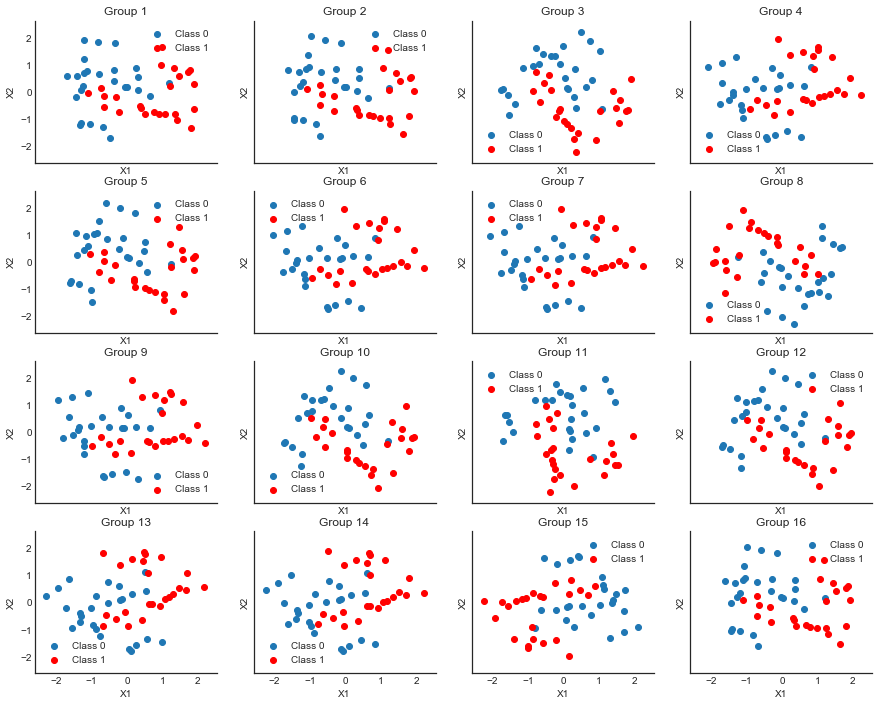

In [4]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Group {}'.format(i + 1), xlabel='X1', ylabel='X2')

As you can see, we have 18 groups that share a higher-order structure. However, in the pure data space, no single classifier will be able to do a good job here. Also, because we only have 50 data points in each class, a NN will likely have a hard time producing robust results. But let's actually test this.

## Classify each group separately

The code for the NN below is explained in my previous blog post.

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = floatX(np.random.randn(X.shape[1], n_hidden))
    init_2 = floatX(np.random.randn(n_hidden, n_hidden))
    init_out = floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output)
    return neural_network

Loop over the groups and fit a BNN to each one.

In [7]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test):
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
    neural_network = construct_nn(ann_input, ann_output)
    
    with neural_network:
        inference = pm.ADVI()
        approx = pm.fit(n=20000, method=inference)
        trace = approx.sample(draws=500)
        #trace = pm.sample(init='advi+adapt_diag') #
        ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False)
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
        Ys_pred_train.append(pred_train)
        
        # Make predictions on test-set
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

        pred_test = ppc_test['out'].mean(axis=0) > 0.5
        Ys_pred_test.append(pred_test)
        
        # Evaluate classifier over grid
        ann_input.set_value(grid_2d)
        ann_output.set_value(dummy_out)
        ppc_grid = pm.sample_ppc(trace, samples=500, progressbar=False)
        grid_eval.append(ppc_grid['out'])

Average Loss = 38.199: 100%|██████████| 20000/20000 [00:15<00:00, 1267.54it/s]
Finished [100%]: Average Loss = 38.201
Average Loss = 39.222: 100%|██████████| 20000/20000 [00:15<00:00, 1316.42it/s]
Finished [100%]: Average Loss = 39.234
Average Loss = 38.586: 100%|██████████| 20000/20000 [00:16<00:00, 1209.67it/s]
Finished [100%]: Average Loss = 38.604
Average Loss = 38.714: 100%|██████████| 20000/20000 [00:21<00:00, 941.86it/s]
Finished [100%]: Average Loss = 38.696
Average Loss = 38.878: 100%|██████████| 20000/20000 [00:14<00:00, 1356.83it/s]
Finished [100%]: Average Loss = 38.895
Average Loss = 38.577: 100%|██████████| 20000/20000 [00:14<00:00, 1358.25it/s]
Finished [100%]: Average Loss = 38.61
Average Loss = 38.818: 100%|██████████| 20000/20000 [00:15<00:00, 1297.43it/s]
Finished [100%]: Average Loss = 38.796
Average Loss = 38.414: 100%|██████████| 20000/20000 [00:14<00:00, 1336.59it/s]
Finished [100%]: Average Loss = 38.431
Average Loss = 38.311: 100%|██████████| 20000/20000 [00:15

In [8]:
Ys_pred_train = np.stack(Ys_pred_train)
Ys_pred_test = np.stack(Ys_pred_test)
ppc_grid_single = np.stack(grid_eval)

In [9]:
print ("Train accuracy = {:.2f}%".format(100*np.mean(Ys_pred_train == Ys_train)))

Train accuracy = 78.89%


In [10]:
print ("Test accuracy = {:.2f}%".format(100*np.mean(Ys_pred_test == Ys_test)))

Test accuracy = 89.78%


OK, that doesn't seem that bad. I'm a bit stumped that test accuracy is higher than train accuracy. It seems like a bug but I can't see it, please let me know in the comments section if you know what's going on. Could just be noise too. Moving on...

Now let's look at the decision surfaces -- i.e. what the classifier thinks about each point in the data space.

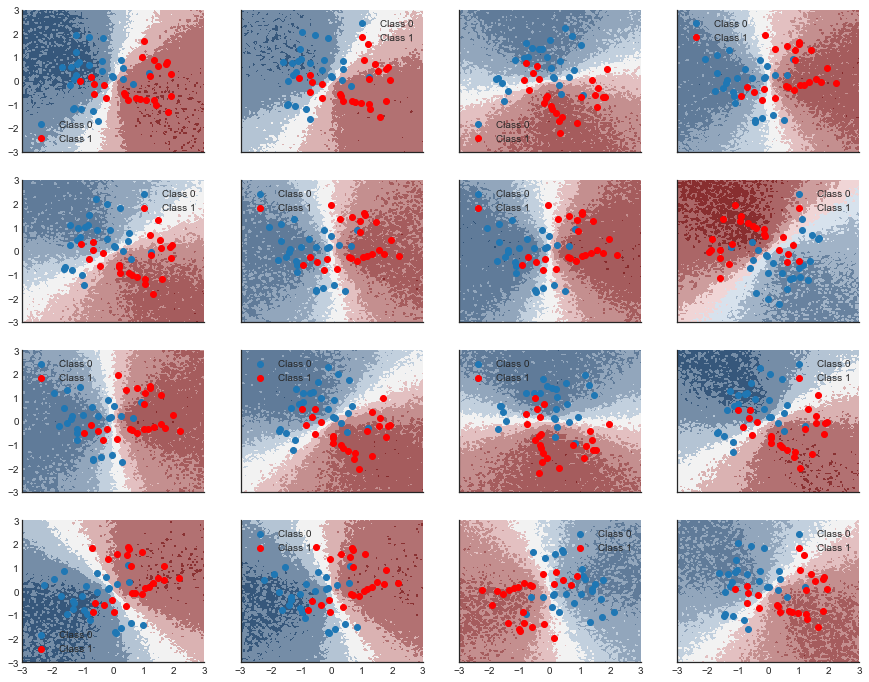

In [11]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

That doens't look all that convincing. We know from the data generation process as well as from the previous blog posts using this process that it should be "Z"-shaped decision surface. So what happens is that because we have so few data points a linear separation is chosen.

As we are in a Bayesian framework, we can also look at the uncertainty.

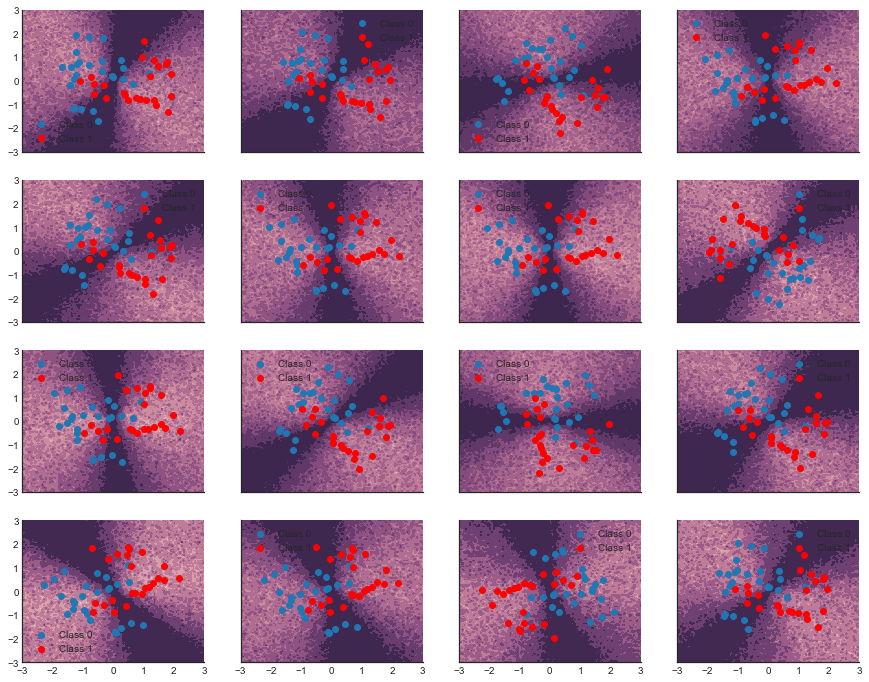

In [12]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid_single[i, ...].std(axis=0).reshape(100, 100), 
                          cmap=cmap_uncertainty)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

Uncertainty galore! Overall, I'm sure you agree that this is not a satisfying fit.

## Hierarchical Bayesian Neural Network

Ready for something cool?

It's actually quite straight-forward to turn this into a hierarchical model. Let's call the weight connecting neuron $i$ in layer 1 to neuron $j$ in layer 2 $w_{i, j}$. Rather than placing a fixed prior as we did above (i.e. $ w_{i, j} \sim \mathcal{N}(0, 1^2)$), we will assume that each weight comes from an overarching group distribution:
$ w_{i, j} \sim \mathcal{N}(\mu_{i, j}, \sigma^2)$. The key is that we will estimate $\mu_{i, j}$ and $\sigma^2$ simultaneously from data. Why not allow for different $\sigma_{i,j}^2$ per connection? Mainly just to make our life simpler.

Note that we create a very rich model here. Every individual weight has its own hierarchical structure with a single group mean parameter and 16 per-group weights distributed around the group mean, while the group variability is shared per layer. While this create a big amount of group distributions there is no problem with this per-se, although it might be a bit unusual. One might argue that this model is quite complex and while that's true, in terms of degrees-of-freedom, this model simpler than the unpooled one above.

As for the code, we stack weights along a 3rd dimenson to get separate weights for each group. That way, through the power of broadcasting, the linear algebra works out almost the same as before.

In [14]:
def construct_hierarchical_nn(Xs, Ys):
    n_hidden = 5
    n_grps = Xs.shape[0].eval()
    n_data = Xs.shape[2].eval()
    # Initialize random weights between each layer
    init_1 = floatX(np.random.randn(n_data, n_hidden))
    init_2 = floatX(np.random.randn(n_hidden, n_hidden))
    init_out = floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Group mean distribution for input to hidden layer
        weights_in_1_grp = pm.Normal('w_in_1_grp', 0, sd=1, 
                                 shape=(n_data, n_hidden), 
                                 testval=init_1)
        # Group standard-deviation
        weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.)
        
        # Group mean distribution for weights from 1st to 2nd layer
        weights_1_2_grp = pm.Normal('w_1_2_grp', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        weights_1_2_grp_sd = pm.HalfNormal('w_1_2_grp_sd', sd=1.)
        
        # Group mean distribution from hidden layer to output
        weights_2_out_grp = pm.Normal('w_2_out_grp', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.)
    
        # Separate weights for each different model, just add a 3rd dimension
        # of weights
        weights_in_1_raw = pm.Normal('w_in_1', shape=(n_grps, n_data, n_hidden))
        # Non-centered specification of hierarchical model
        weights_in_1 = weights_in_1_raw * weights_in_1_grp_sd + weights_in_1_grp
        
        weights_1_2_raw = pm.Normal('w_1_2', shape=(n_grps, n_hidden, n_hidden))
        weights_1_2 = weights_1_2_raw * weights_1_2_grp_sd + weights_1_2_grp
        
        weights_2_out_raw = pm.Normal('w_2_out', shape=(n_grps, n_hidden))
        
        weights_2_out = weights_2_out_raw * weights_2_out_grp_sd + weights_2_out_grp
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(tt.batched_dot(Xs, weights_in_1))
        act_2 = pm.math.tanh(tt.batched_dot(act_1, weights_1_2))
        act_out = pm.Deterministic('act_out', tt.batched_dot(act_2, weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', logit_p=act_out, observed=Ys)
        
    return neural_network

In [16]:
ann_input_hier = theano.shared(Xs_train)
ann_output_hier = theano.shared(Ys_train)

hierarchical_neural_network = construct_hierarchical_nn(ann_input_hier, ann_output_hier)

with hierarchical_neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=100000, method=inference)
    
    trace_hier = approx.sample(draws=500)
    ppc_train = pm.sample_ppc(trace_hier, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    Ys_hierarchical_pred_train = ppc_train['out'].mean(axis=0) > 0.5

    ann_input_hier.set_value(Xs_test)
    ann_output_hier.set_value(Ys_test)
    ppc_test = pm.sample_ppc(trace_hier, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    Ys_hierarchical_pred_test = ppc_test['out'].mean(axis=0) > 0.5

Average Loss = 480.36: 100%|██████████| 100000/100000 [01:59<00:00, 838.72it/s]
Finished [100%]: Average Loss = 480.44


In [477]:
%%time
ann_input_hier = theano.shared(Xs_train)
ann_output_hier = theano.shared(Ys_train)

hierarchical_neural_network = construct_hierarchical_nn(ann_input_hier, ann_output_hier)

with hierarchical_neural_network:
    trace_nuts = pm.sample(init='advi+adapt_diag', tune=2000, chains=1)
    
    ppc_train = pm.sample_ppc(trace_nuts, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    Ys_hierarchical_pred_train = ppc_train['out'].mean(axis=0) > 0.5

    ann_input_hier.set_value(Xs_test)
    ann_output_hier.set_value(Ys_test)
    ppc_test = pm.sample_ppc(trace_nuts, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    Ys_hierarchical_pred_test = ppc_test['out'].mean(axis=0) > 0.5

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 493.76:  19%|█▉        | 38341/200000 [00:45<03:10, 847.94it/s]
Convergence achieved at 38400
Interrupted at 38,399 [19%]: Average Loss = 582.05
Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1, w_2_out_grp_sd, w_2_out_grp, w_1_2_grp_sd, w_1_2_grp, w_in_1_grp_sd, w_in_1_grp]
100%|██████████| 2500/2500 [06:33<00:00,  6.36it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 7min 33s, sys: 19.1 s, total: 7min 52s
Wall time: 7min 48s


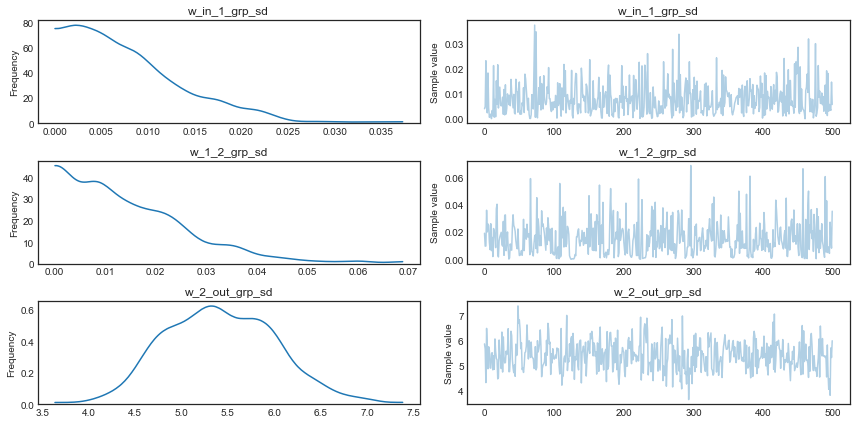

In [465]:
pm.traceplot(trace_nuts, varnames=['w_in_1_grp_sd', 'w_1_2_grp_sd', 'w_2_out_grp_sd']);

Looking at the ELBO we see that our variational inference seems to have found a local minimum.

In [454]:
special.expit(np.abs(trace_nuts['act_out'])).mean(axis=0).mean(-1)

array([0.95197365, 0.9527226 , 0.95287404, 0.96037234, 0.95577413,
       0.95960954, 0.95945611, 0.95067832, 0.95848764, 0.95808967,
       0.93011702, 0.95706742, 0.95005723, 0.95761542, 0.95548613,
       0.95358246, 0.93405705, 0.95620945])

In [455]:
(Ys_hierarchical_pred_train == Ys_train).mean(-1)

array([0.98, 0.98, 1.  , 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.96,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 1.  ])

In [459]:
(Ys_hierarchical_pred_test == Ys_test).mean(-1)

array([0.94, 0.94, 0.94, 0.9 , 0.92, 0.9 , 0.9 , 0.92, 0.92, 0.94, 0.92,
       0.94, 0.92, 0.92, 0.9 , 0.94, 0.9 , 0.94])

In [460]:
print('Train accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 98.11%


In [461]:
print('Test accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 92.22%


In [462]:
(Ys_hierarchical_pred_test == Ys_test).shape

(18, 50)

In [456]:
(Ys_hierarchical_pred_test == Ys_test).std(axis=0)

array([0.        , 0.47140452, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.49690399, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Great -- we get higher train *and* test accuracy. Let's look at what the classifier has learned for each level.

In [468]:
ann_input.shape.eval()

array([18, 50,  2])

In [17]:
grid_3d = np.repeat(grid_2d[None, ...], n_grps, axis=0)
dummy_out_3d = np.ones((n_grps, grid.shape[1]), dtype=np.int8)

ann_input_hier.set_value(grid_3d)
ann_output_hier.set_value(dummy_out_3d)

with hierarchical_neural_network:
    ppc_grid = pm.sample_ppc(trace_hier, samples=500, progressbar=False)
    #ppc_grid = pm.sample_ppc(trace_nuts, samples=500, progressbar=False)

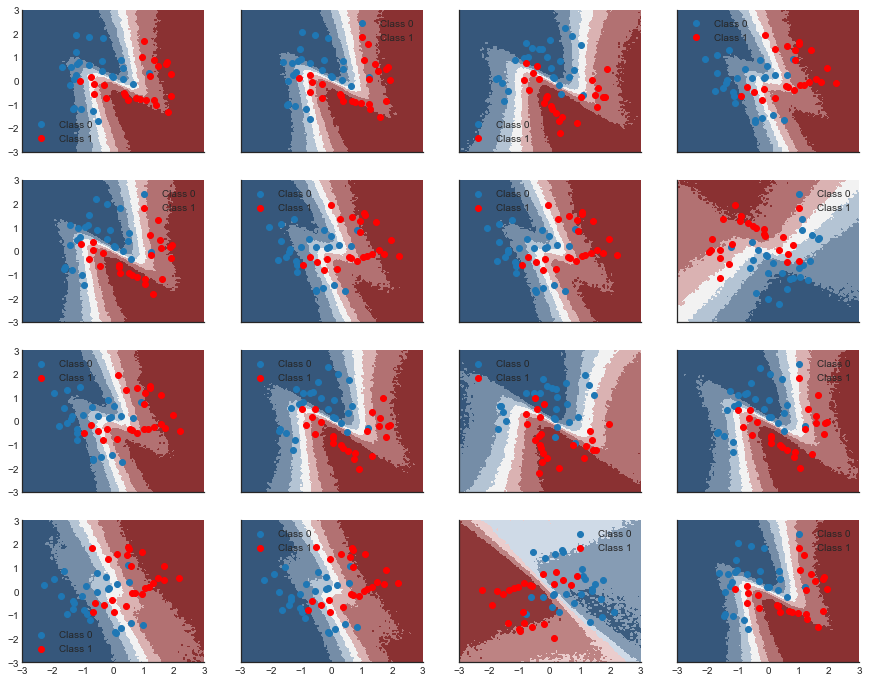

In [18]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid['out'][:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

Awesome! By (partially) pooling the data we have for each individual group we actually manage to retrieve the non-linearity. This is the strength of hierarchical models. We model the group-wise similarities *and* their differences, sharing statistical power to the degree it's useful. 

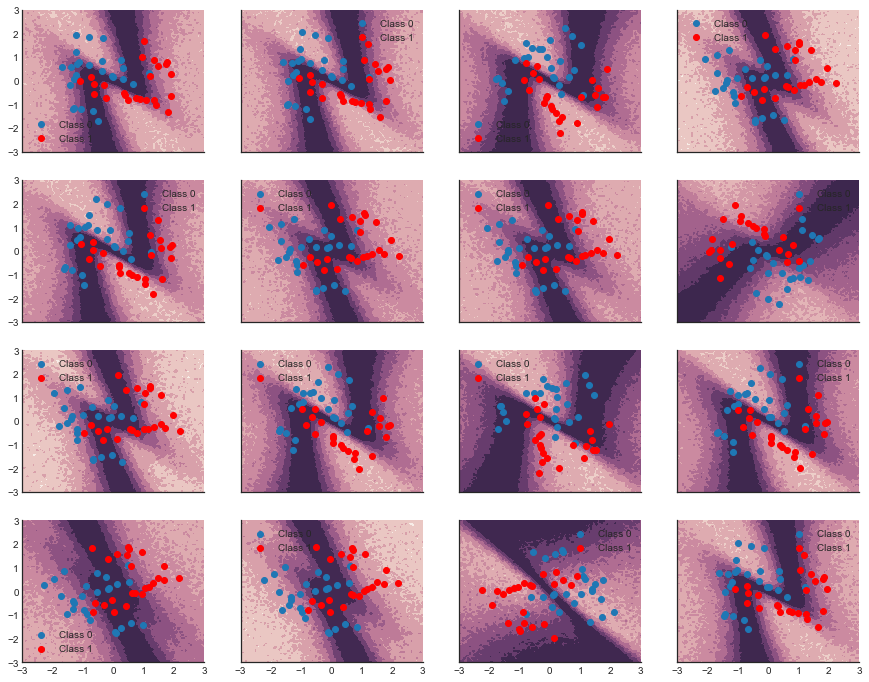

In [19]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid['out'][:, i, :].std(axis=0).reshape(100, 100), 
                          cmap=cmap_uncertainty)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

We are also much more certain in our predictions which is a good sign.

## Further analysis

There are a couple of things we might ask at this point. For example, how much does each layer specialize it's weight per group. To answer this we can look at the group standard-deviation which informs us how much each weight is allowed to deviate from its group mean.

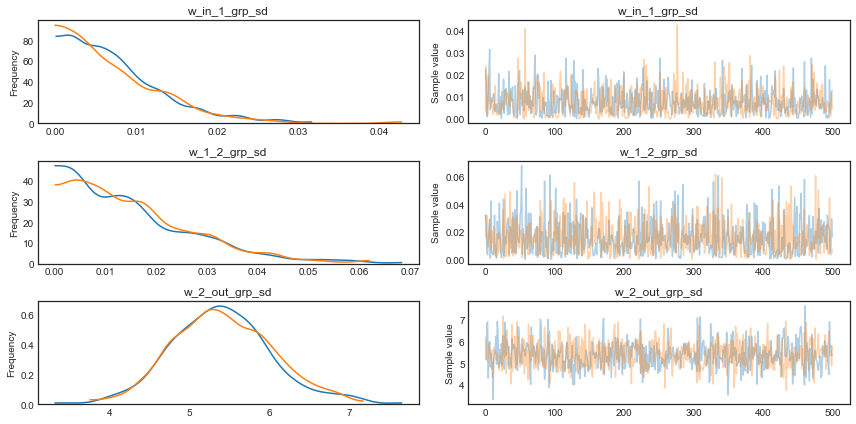

In [241]:
pm.traceplot(trace_nuts, varnames=['w_in_1_grp_sd', 'w_1_2_grp_sd', 'w_2_out_grp_sd']);

Interestingly, it seems that the specialization of the per-group-model is happening at the last layer where weights change most strongly from their group mean. I had assumed that this would happen at the first layer.

Another interesting property of hierarchical models reveals itself here. As the group standard deviation is small for the weights in layers 1 and 2, it means these weights will be close to their group mean. This is very different from the separate model approach above.  

Next, we might be interested in whether individual weights in a layer change more between groups than other weights. For this, we look at the standard-deviation of weights over groups on a per-connection basis.

Finally, I wondered what the group-model actually learned. To get at that, we can use the trace of $\mu_{i,j}$ from the hierarchical model and pass it to the non-hierarchical model as if we trained these weights directly on a single data set. 

In [21]:
trace._straces[0].samples['w_in_1'] = trace_hier['w_in_1_grp']
trace._straces[0].samples['w_1_2'] = trace_hier['w_1_2_grp']
trace._straces[0].samples['w_2'] = trace_hier['w_2_out_grp']

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

with neural_network:
    # Evaluate classifier over grid
    ann_input.set_value(grid_2d)
    ann_output.set_value(dummy_out)
    ppc_grid_hier2 = pm.sample_ppc(trace, samples=500, progressbar=False)['out']

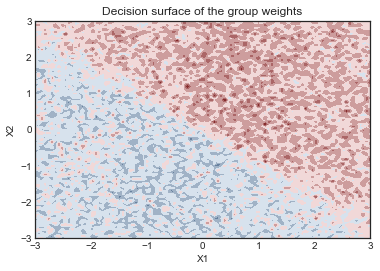

In [23]:
contour = plt.contourf(grid[0], grid[1], ppc_grid_hier2.mean(axis=0).reshape(100, 100), cmap=cmap)
plt.xlabel('X1'); plt.ylabel('X2'); plt.title('Decision surface of the group weights');

## Informative priors for Bayesian Neural Networks

In [24]:
trace_nuts = trace_hier

In [27]:
from collections import defaultdict
samples_tmp = defaultdict(list)
samples = {}
layer_names = ['w_in_1_grp', 'w_1_2_grp', 'w_2_out_grp']

for layer_name in layer_names:
    for mu, sd in zip(trace_nuts.get_values(layer_name, chains=0),
                      trace_nuts.get_values(layer_name+'_sd', chains=0)):
        for _ in range(20):
            samples_tmp[layer_name].append(stats.norm(mu, sd).rvs())
    samples[layer_name] = np.asarray(samples_tmp[layer_name])

In [28]:
def construct_nn_prior(ann_input, ann_output, prior_1_mu, prior_1_sd, prior_2_mu, prior_2_sd, prior_out_mu, prior_out_sd):
    n_hidden = 5
          
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', prior_1_mu, sd=prior_1_sd, 
                                 shape=(X.shape[1], n_hidden))
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', prior_2_mu, sd=prior_2_sd, 
                                shape=(n_hidden, n_hidden))
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', prior_out_mu, sd=prior_out_sd, 
                                  shape=(n_hidden,))
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           logit_p=act_out,
                           observed=ann_output)
    return neural_network

In [481]:
def construct_nn_prior(ann_input, ann_output, prior_1_mu, prior_1_cov, prior_2_mu, prior_2_cov, prior_out_mu, prior_out_cov):
    n_hidden = 5
          
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.MvNormal('w_in_1', prior_1_mu.flatten(), cov=prior_1_cov, shape=prior_1_cov.shape[0]).reshape((X.shape[1], n_hidden))
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.MvNormal('w_1_2', prior_2_mu.flatten(), cov=prior_2_cov, shape=prior_2_cov.shape[0]).reshape((n_hidden, n_hidden))
        
        # Weights from hidden layer to output
        weights_2_out = pm.MvNormal('w_2_out', prior_out_mu.flatten(), cov=prior_out_cov, shape=prior_out_cov.shape[0]).reshape((n_hidden,))
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           logit_p=act_out,
                           observed=ann_output)
    return neural_network

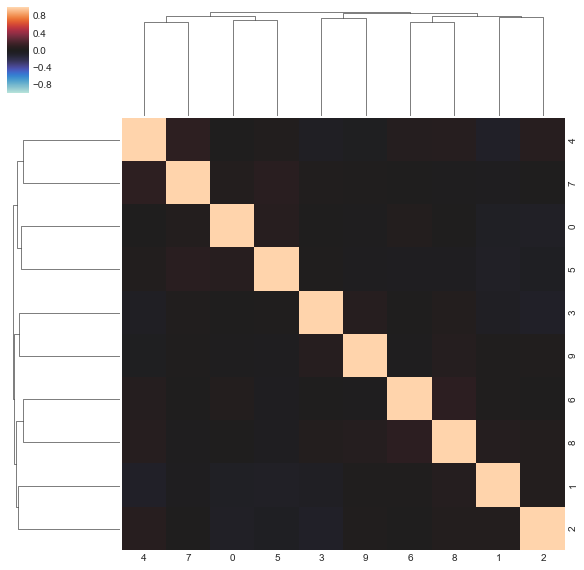

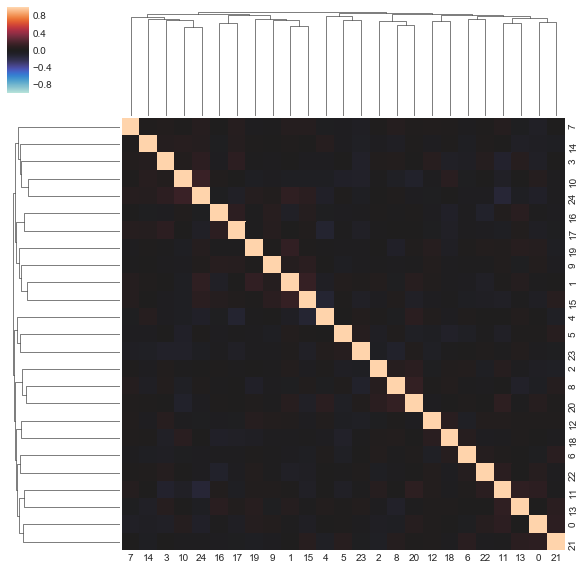

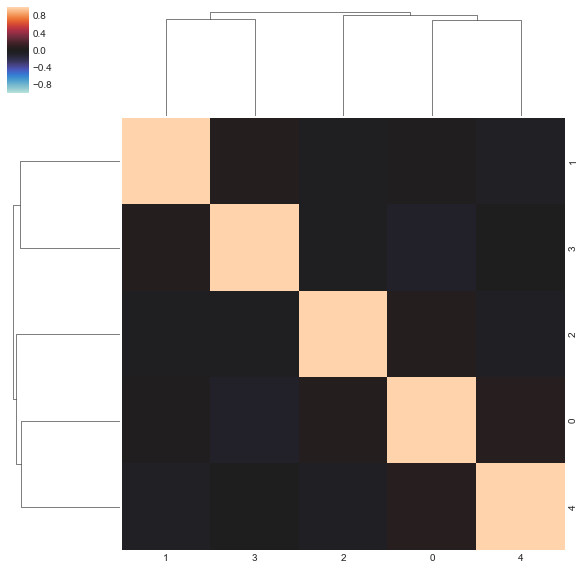

In [29]:
for layer_name in layer_names:
    sns.clustermap(np.corrcoef(trace_nuts[layer_name].reshape((trace_nuts[layer_name].shape[0], -1)).T), vmin=-1, center=0, vmax=1)

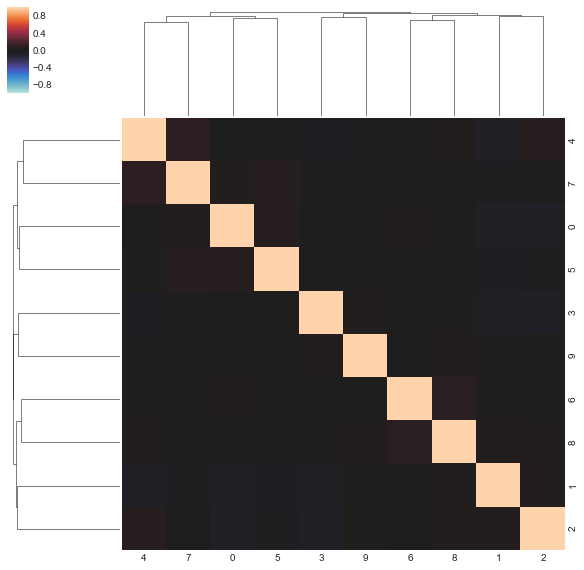

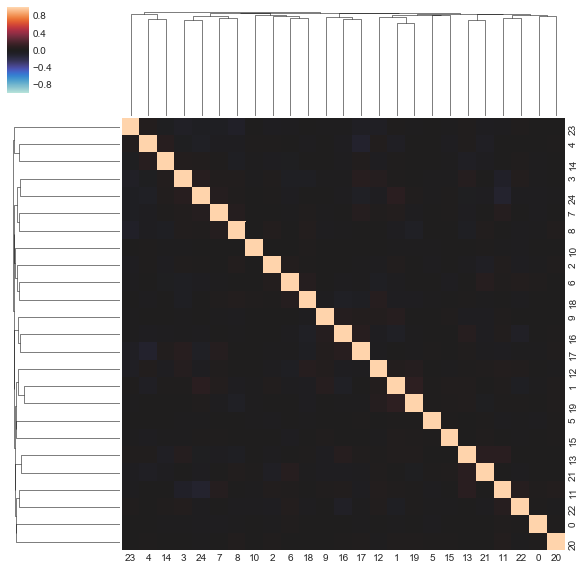

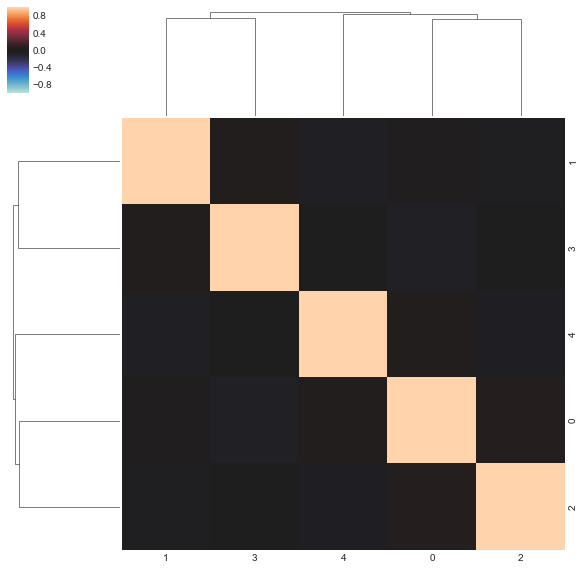

In [30]:
for layer_name in layer_names:
    sns.clustermap(np.corrcoef(samples[layer_name].reshape((samples[layer_name].shape[0], -1)).T), vmin=-1, center=0, vmax=1)

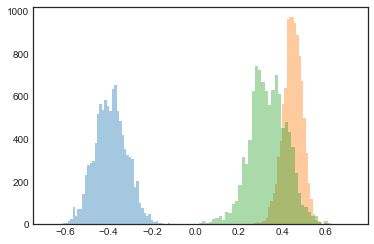

In [31]:
sns.distplot(samples['w_in_1_grp'][:, 0, 0], kde=False)
sns.distplot(samples['w_in_1_grp'][:, 0, 1], kde=False)
sns.distplot(samples['w_in_1_grp'][:, 1, 0], kde=False)

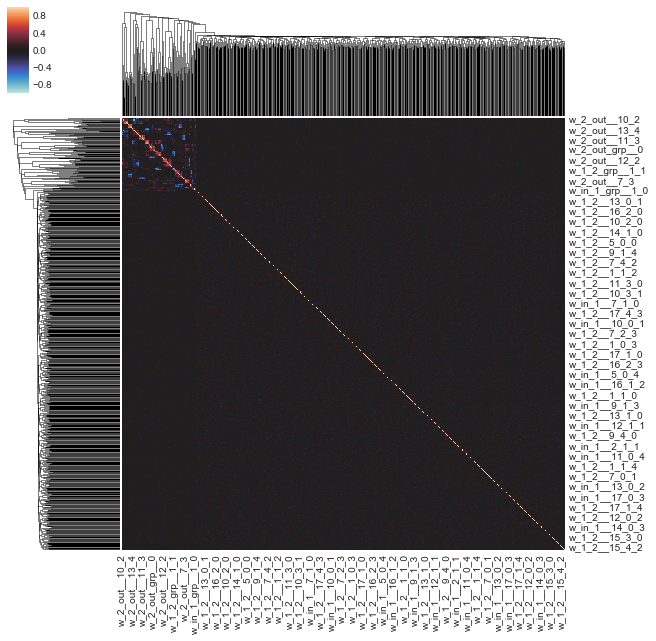

In [381]:
sns.clustermap(trace_df[trace_df.columns[~trace_df.columns.str.contains('act')]].corr(), vmin=-1, center=0, vmax=1)

In [33]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test):
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
    n_samples = trace_nuts['w_in_1_grp'].shape[0]
    neural_network = construct_nn_prior(ann_input, 
                                        ann_output, 
                                        samples['w_in_1_grp'].mean(axis=0),
                                        samples['w_in_1_grp'].std(axis=0),
                                        samples['w_1_2_grp'].mean(axis=0),
                                        samples['w_1_2_grp'].std(axis=0),
                                        samples['w_2_out_grp'].mean(axis=0),
                                        samples['w_2_out_grp'].std(axis=0),
                                        )
        
#     neural_network = construct_nn_prior(ann_input, 
#                                         ann_output, 
#                                         samples['w_in_1_grp'],
#                                         samples['w_1_2_grp'],
#                                         samples['w_2_out_grp']
#                                         )
    
    with neural_network:
        inference = pm.ADVI()
        approx = pm.fit(n=50000, method=inference)
        trace = approx.sample(draws=500)
        #trace = pm.sample()
        ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False)
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
        Ys_pred_train.append(pred_train)
        
        # Make predictions on test-set
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

        pred_test = ppc_test['out'].mean(axis=0) > 0.5
        Ys_pred_test.append(pred_test)
        
        # Evaluate classifier over grid
        ann_input.set_value(grid_2d)
        ann_output.set_value(dummy_out)
        ppc_grid = pm.sample_ppc(trace, samples=500, progressbar=False)
        grid_eval.append(ppc_grid['out'])

Average Loss = 16.869: 100%|██████████| 50000/50000 [00:40<00:00, 1242.52it/s]
Finished [100%]: Average Loss = 16.859
Average Loss = 15.457: 100%|██████████| 50000/50000 [00:37<00:00, 1316.31it/s]
Finished [100%]: Average Loss = 15.458
Average Loss = 21.125: 100%|██████████| 50000/50000 [00:38<00:00, 1293.08it/s]
Finished [100%]: Average Loss = 21.132
Average Loss = 23.597: 100%|██████████| 50000/50000 [00:38<00:00, 1287.49it/s]
Finished [100%]: Average Loss = 23.594
Average Loss = 15.384: 100%|██████████| 50000/50000 [00:38<00:00, 1282.81it/s]
Finished [100%]: Average Loss = 15.38
Average Loss = 22.999: 100%|██████████| 50000/50000 [00:39<00:00, 1256.23it/s]
Finished [100%]: Average Loss = 22.998
Average Loss = 23.166: 100%|██████████| 50000/50000 [00:38<00:00, 1314.08it/s]
Finished [100%]: Average Loss = 23.173
Average Loss = 34.122: 100%|██████████| 50000/50000 [00:37<00:00, 1343.41it/s]
Finished [100%]: Average Loss = 34.116
Average Loss = 22.016: 100%|██████████| 50000/50000 [00:3

In [537]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test):
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
    n_samples = samples['w_in_1_grp'].shape[0]
    neural_network = construct_nn_prior(ann_input, 
                                        ann_output, 
                                        samples['w_in_1_grp'].mean(axis=0),
                                        np.cov(samples['w_in_1_grp'].reshape((n_samples, -1)).T),
                                        samples['w_1_2_grp'].mean(axis=0),
                                        np.cov(samples['w_1_2_grp'].reshape((n_samples, -1)).T),
                                        samples['w_2_out_grp'].mean(axis=0),
                                        np.cov(samples['w_2_out_grp'].reshape((n_samples, -1)).T),
                                        )
    
    with neural_network:
        #inference = pm.ADVI()
        #approx = pm.fit(n=50000, method=inference)
        trace = pm.sample() #
        ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False)
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
        Ys_pred_train.append(pred_train)
        
        # Make predictions on test-set
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

        pred_test = ppc_test['out'].mean(axis=0) > 0.5
        Ys_pred_test.append(pred_test)
        
        # Evaluate classifier over grid
        ann_input.set_value(grid_2d)
        ann_output.set_value(dummy_out)
        ppc_grid = pm.sample_ppc(trace, samples=500, progressbar=False)
        grid_eval.append(ppc_grid['out'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:47<00:00,  9.34draws/s]
The acceptance probability does not match the target. It is 0.8837528745762878, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:42<00:00, 19.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:58<00:00, 15.06draws/s]
The estimated number

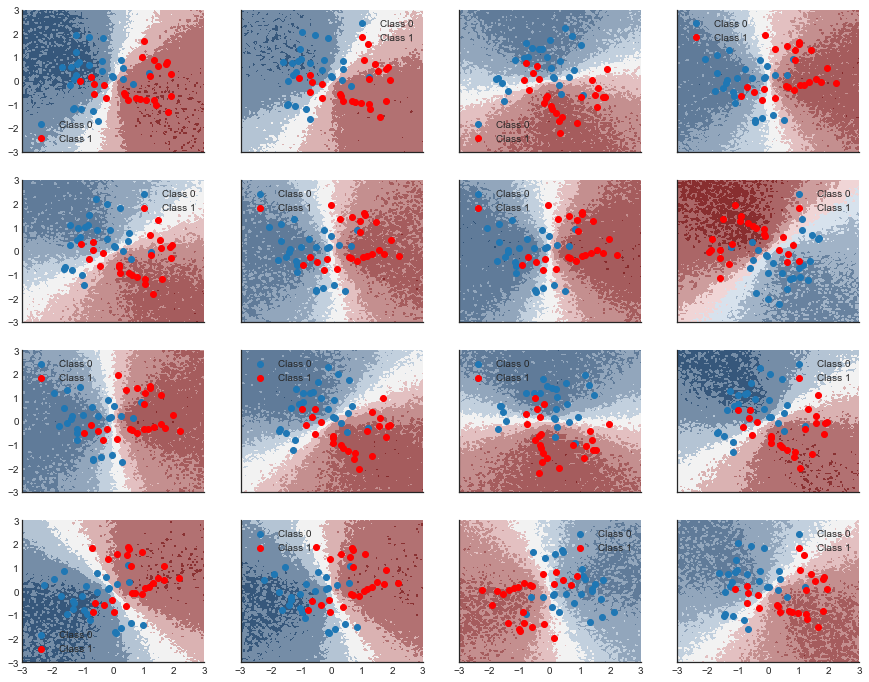

In [35]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()